In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16739179272825069528
xla_global_id: -1
]


Імпорт необхідних бібліотек:

In [3]:
from keras.datasets import fashion_mnist
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Flatten, BatchNormalization, Activation
from keras import callbacks

Поділ на тренувальні та тестові набори

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 2s 0us/step


In [5]:
x_train = x_train.reshape(60000, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(10000, 28, 28, 1).astype('float32') / 255

Архітектура LeNet5:

In [6]:
model = Sequential([
    Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(strides=2),
    Conv2D(48, (5,5), padding='valid', activation='relu'),
    MaxPooling2D(strides=2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(84, activation='relu'),
    Dense(10, activation='softmax')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 48)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 256)               3

In [8]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Тренування моделі:

In [13]:
model_history = model.fit(
    x_train, y_train,
    batch_size=128,
    epochs=30,
    verbose=1,
    validation_data=(x_test, y_test)
)

Epoch 1/30
469/469 [==============================] - 25s 53ms/step - loss: 0.2680 - accuracy: 0.9017 - val_loss: 0.3002 - val_accuracy: 0.8910
Epoch 2/30
469/469 [==============================] - 23s 50ms/step - loss: 0.2418 - accuracy: 0.9112 - val_loss: 0.2619 - val_accuracy: 0.9062
Epoch 3/30
469/469 [==============================] - 23s 49ms/step - loss: 0.2181 - accuracy: 0.9198 - val_loss: 0.2605 - val_accuracy: 0.9063
Epoch 4/30
469/469 [==============================] - 23s 49ms/step - loss: 0.2017 - accuracy: 0.9249 - val_loss: 0.2567 - val_accuracy: 0.9048
Epoch 5/30
469/469 [==============================] - 23s 50ms/step - loss: 0.1829 - accuracy: 0.9322 - val_loss: 0.2574 - val_accuracy: 0.9076
Epoch 6/30
469/469 [==============================] - 23s 48ms/step - loss: 0.1700 - accuracy: 0.9372 - val_loss: 0.2407 - val_accuracy: 0.9166
Epoch 7/30
469/469 [==============================] - 23s 49ms/step - loss: 0.1530 - accuracy: 0.9431 - val_loss: 0.2739 - val_accuracy:

Збережемо ваги можделі для подальшого використання:

In [14]:
model.save('lenet.h5')

Генерація ознак:

In [15]:
from keras.layers import concatenate

img_a_in = Input(shape = x_train.shape[1:], name = 'image1')
img_b_in = Input(shape = x_train.shape[1:], name = 'image2')

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)

features = concatenate([img_a_feat, img_b_feat], name = 'merge_features')
features = Dense(64, activation='linear')(features)
features = BatchNormalization()(features)
features = Activation('relu')(features)
features = Dense(32, activation='linear')(features)
features = BatchNormalization()(features)
features = Activation('relu')(features)
features = Dense(1, activation='sigmoid')(features)

Генеруємо фічі за допомогою siamese моделі:

In [16]:
siamese_model = Model(inputs = [img_a_feat, img_b_feat], outputs = [features], name = 'Siamese_model')
siamese_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['mae'])
siamese_model.summary()

Model: "Siamese_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 64)           1344        ['merge_features[1][0

Реорганізація на групи:

In [17]:
import numpy as np

train_groups = [x_train[np.where(y_train == i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test == i)[0]] for i in np.unique(y_train)]

In [18]:
print("train groups:", [x.shape[0] for x in train_groups])
print("test groups:", [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [19]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1] * batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize

        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

# Візуалізація даних

1/1 [==============================] - 0s 64ms/step


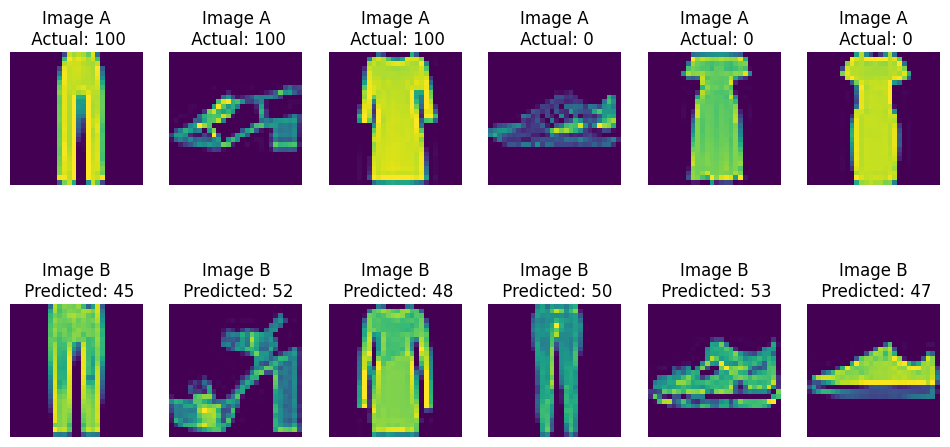

In [20]:
import matplotlib.pyplot as plt

def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = siamese_model.predict([model.predict(pv_a), model.predict(pv_b)])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim, m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title(f'Image A\n Actual: { 100 * c_d }')
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title(f'Image B\n Predicted: {int( 100 * p_d[0] )}')
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()

Тренування моделі:

In [21]:
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [model.predict(pv_a), model.predict(pv_b)], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = siamese_model.fit(siam_gen(train_groups),
    steps_per_epoch = 50,
    validation_data=([model.predict(valid_a), model.predict(valid_b)],
    valid_sim),
    epochs = 10,
    verbose = True)

1/1 [==============================] - 0s 17ms/step
Epoch 1/10
50/50 [==============================] - 7s 118ms/step - loss: 0.5184 - mae: 0.3850 - val_loss: 0.6241 - val_mae: 0.4622
Epoch 2/10
50/50 [==============================] - 5s 109ms/step - loss: 0.2384 - mae: 0.2036 - val_loss: 0.5394 - val_mae: 0.4074
Epoch 3/10
50/50 [==============================] - 5s 108ms/step - loss: 0.1289 - mae: 0.1081 - val_loss: 0.4517 - val_mae: 0.3428
Epoch 4/10
1/1 [==============================] - 0s 38ms/step
Epoch 5/10
50/50 [==============================] - 6s 113ms/step - loss: 0.0682 - mae: 0.0498 - val_loss: 0.2893 - val_mae: 0.2159
Epoch 6/10
50/50 [==============================] - 5s 111ms/step - loss: 0.0378 - mae: 0.0303 - val_loss: 0.2346 - val_mae: 0.1592
Epoch 7/10
50/50 [==============================] - 5s 110ms/step - loss: 0.0389 - mae: 0.0288 - val_loss: 0.2087 - val_mae: 0.1173
Epoch 8/10
50/50 [==============================] - 5s 108ms/step - loss: 0.0542 - mae: 0.030

1/1 [==============================] - 0s 16ms/step


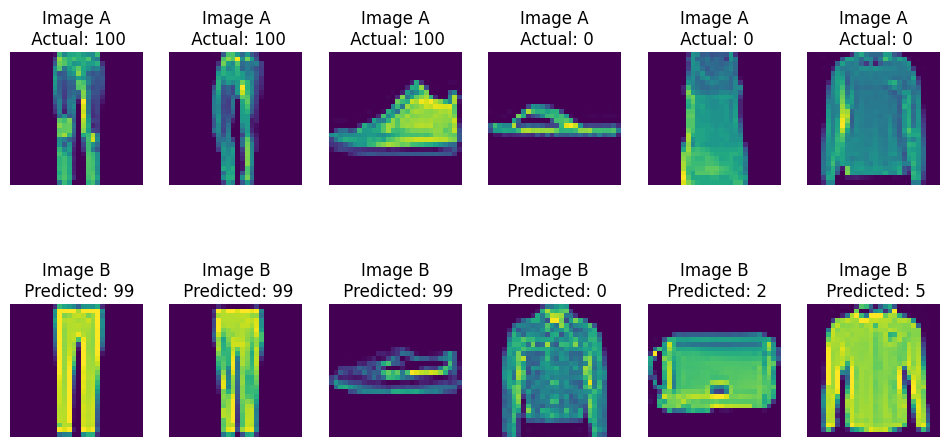

In [22]:
_ = show_model_output()

# Перевірка фічей
Перевіримо чи генерувались корисні фічі за допомогою моделі Feature Generation.
Для цього скористаємося T-розподіленим стохастичним вбудовуванням сусідів.
(нелінійне зменшення розмірності)

In [23]:
from sklearn.manifold import TSNE
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

tsne_obj = TSNE(n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=1)
tsne_features = tsne_obj.fit_transform(x_test_features)

79/79 [==============================] - 1s 11ms/step
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.018s...
[t-SNE] Computed neighbors for 10000 samples in 0.523s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.054581
[t-SNE] KL divergence aft

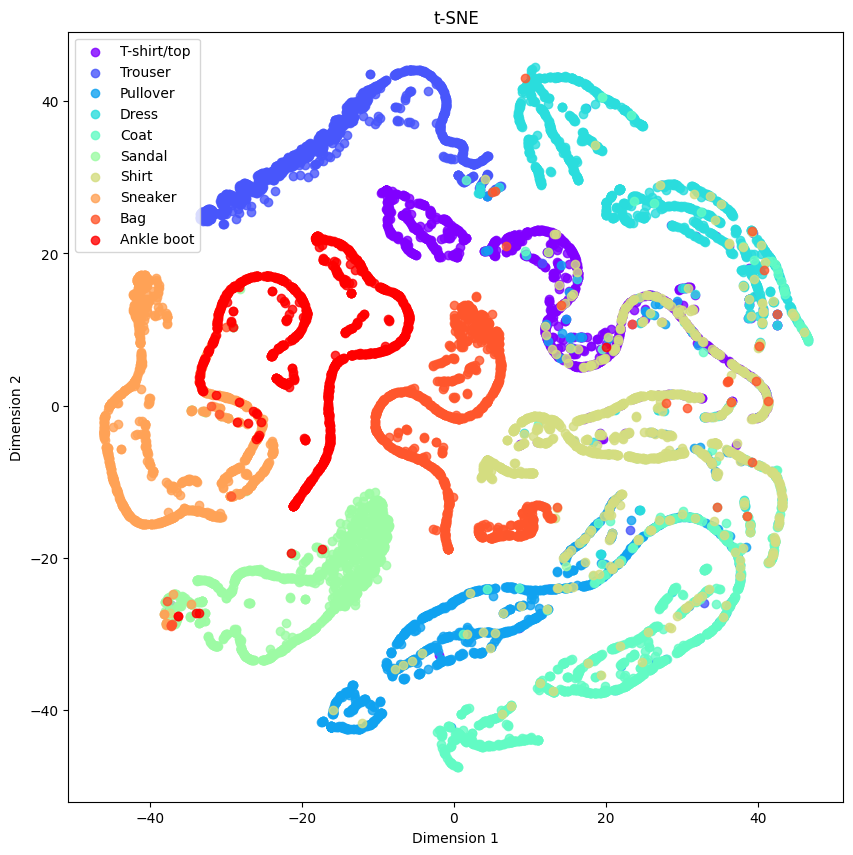

In [25]:
obj_categories = [
                    'T-shirt/top','Trouser','Pullover','Dress',
                    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
                 ]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)